## K-Armed Bandits example
### Definitions
$q_*(a)=E[R_t|A_t=a]$: Value of an arbitrary action $a$ is the expected reward given that $a$ is selected <br/>
$a:$ Set of all possible actions <br/>
$Q_i(a):$ Action-value estimates at step i for any action <br/>
$A_i:$ Action taken at step i <br/>
$R_i:$ Reward obtained for action A_i <br/>

### Sample averages

We need to approximate $q_*(a)$, a simple way to do this is to average the rewards obtained so far for each action, this is called the sample-average method. $Q_t(a)$ converges to $q_*(a)$ for large numbers.  

$Q_t(a) = \frac{\text{sum of rewards when a taken prior to t}}{\text{sum of times a taken prior to t}} = \frac{\sum_{i=1}^{t-1}R_i \cdot \mathrm{I}_{A_i=a}}{\sum_{i=1}^{t-1}\mathrm{I}_{A_i=a}}$ 

Where $\mathrm{I} = 1$ if $A_i = a$ and $0$ if not, for all $a$. 

#### Incremental implementation 

The calculation of $Q_t(a)$ as written above is not computationally efficient since we need to recover all the values prior to $t$, a faster implementation would be to write $Q$ for a single action after it has been selected $n-1$ times as:

$Q_n = \frac{\sum_{i=1}^{n-1}R_i}{n-1}$

$R_i$ is the reward recieved after the $i$-th selection of the action. Then it is possible to write the incremental formula given $Q_n$ and $R_n$:

$Q_{n+1} = \frac{1}{n}\sum_{i=1}^{n}R_i =\frac{1}{n}\left(R_n + \frac{n-1}{n-1}\sum_{i=1}^{n-1}R_i\right) = \frac{1}{n}\left(R_n + (n-1)Q_n\right) = Q_n + \frac{1}{n}\left(R_n-Q_n\right)$

The equation above only needs the information regarding the previous reward and sample average of the last action taken.
### Greedy policy
Now that we have a way to estimate the values of every action, we need a policy to select which action to take at time step $t$ given the previous values. A greedy approach would be to choose the highest value.

$A_t = argmax_a Q_t(a)\rightarrow$Always exploits, no exploration.
#### $\epsilon$-Greedy
Choose action $A_t$ (greedily) with probability $1-\epsilon$, and choose randomly from all possible actions with probability $\epsilon$. This allows to exploit most of the time, while having room for exploration.

An advantage of this method is that $Q_{t\rightarrow \infty}(a) = q_*(a)$ for all $a$, because every action has the possibility ($\epsilon$) of being chosen, and the probability of choosing the optimal policy is $1-\epsilon$.

### Exercise 2.1 
If $\epsilon = 0.5$ there is a $1-0.5$ chance of choosing greedily, however, if the selection is random, the greedy option is still available.

$P(\text{greedy}) = P(\text{greedy}|\text{greed policy})P(\text{greed policy}) + P(\text{greedy}|\text{random policy})P(\text{random policy})$

$= 1\cdot (1-\epsilon) + \frac{1}{|a|}\cdot \epsilon = 0.5+\frac{0.5}{|a|}$

Where $|a|$ is the number of actions available.

### Exercise 2.2

In [16]:
import numpy as np
import time
import random
np.seterr(divide='ignore', invalid='ignore')

import tensorflow_probability as tfp
import tensorflow as tf
tf.enable_eager_execution()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

actions = np.array([1,2,3,4], dtype = np.float32) # possible actions ("a")
action_seq = np.array([1,2,2,2,3], np.float32) # Actions taken (A_i)
rewards = np.array([1,1,2,2,0], np.float32) #Rewards gained (R_i)
Q = np.zeros(actions.shape[0]) #Estimated values

def sample_avg(actions, action_seq, rewards):
    steps = range(1, len(action_seq)+1)
    q = np.zeros((len(steps)+1, len(actions)))
    for t in steps:
        num = np.array([rewards[:t][action_seq[0:t]==i] for i in actions])
        num = np.array([np.sum(num[i]) for i in range(len(num))])
        den = np.sum(np.array([action_seq[0:t]==i for i in actions]), axis = 1)
        q[t,:]=np.where(den == 0, den, num/den)
    return q
q = sample_avg(actions, action_seq, rewards)
print(q, action_seq)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[[0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         1.         0.         0.        ]
 [1.         1.5        0.         0.        ]
 [1.         1.66666667 0.         0.        ]
 [1.         1.66666667 0.         0.        ]] [1. 2. 2. 2. 3.]


Step 1: Greedy (breaking ties randomly) or $\epsilon$, all actions have same Q.<br/>
Step 2: $\epsilon$, didn't choose highest Q action.<br/>
Step 3: Greedy (breaking ties randomly), options 1 and 2 have the same rewards.<br/>
Step 4: Greedy or $\epsilon$, option with highest Q is chosen, could be for greed or randomness.  
Step 5: $\epsilon$, didn't choose highest Q action.

## 10 armed testbed problem implementation

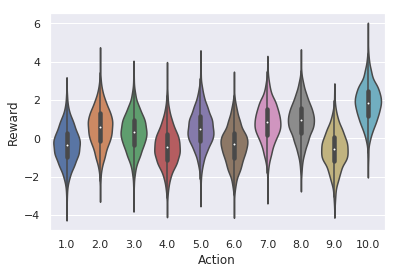

In [147]:
def softmax(values):
    return np.exp(values)/np.sum(np.exp(values))

def multiple_argmax_selection(values):
    """Returns the index of the maximum value of an array, if there are multiple ocurrences, 
    chooses randomly between maximum value indices."""
    values_argmax = [i for i, j in enumerate(values) if j == max(values)]
    if len(values_argmax) == 1:
        values_amax = values_argmax[0]
    else: #break ties randomly
        values_amax = random.choice(values_argmax)
    return values_amax
#Policies
class ActionSelector():
    def __init__(self, values = None, epsilon = None, step = None, stepsize = None, c = None):
        self.values = values
        self.action = None
        self.epsilon = epsilon
        self.step = step
        self.stepsize = stepsize
        self.c = c
    
    def epsilon_greedy(self):
        """Chooses maximum index (action) of an array with probability 1-epsilon 
        or randomly with probability epsilon."""
        if 1 - self.epsilon >= random.random(): #exploitation
            index = multiple_argmax_selection(self.values)
        else: #exploration
            index = np.random.randint(len(self.values)) 
        self.action = index

    def upper_confidence_bound(self):
        """Chooses maximum index of values using upper confidence bound approach.
        c: Coefficient of exploration (higher means more exploration).
        N: Array with number of ocurrences for each action.
        step: Current step. Starts at 0."""
        
        ucb = np.where(np.array(self.stepsize) == 0, np.inf, 
                       self.values + self.c*np.sqrt(np.log(self.step+1)/np.array(self.stepsize)))
        self.action = multiple_argmax_selection(ucb)

    def gradient_bandit_action(self):
        """Choose action based on softmax of preferences (values)."""
        probs = softmax(self.values)
        self.action = np.random.choice(len(self.values), p = probs)

class UpdateMethod():
    def __init__(self, values = None, action_selector = None, stepsize = None, 
                 alpha = None, avg_reward = 0, baseline = True):
        self.values = values
        self.action_selector = action_selector
        self.stepsize = stepsize
        self.alpha = alpha
        self.avg_reward = avg_reward
        self.baseline = baseline
        self.action = None
        
    def sample_avg(self, reward):
        """Updates action-value and number of ocurrences for a given action using sample-average method."""
        n_action = self.stepsize[self.action] + 1
        q_action = (self.values[self.action] + 
                    1/n_action*(reward - self.values[self.action]) )
        self.stepsize[self.action] = n_action
        self.values[self.action] = q_action

        
    def constant_step(self, reward):
        """Updates action-value using contant step size."""
        q = self.values[self.action] + self.alpha*(reward - self.values[self.action])
        self.values[self.action] = q
        
    def gradient_bandit_update(self, reward):
        """Update preferences H using gradient algorithm."""
        H_new = []
        pi = softmax(self.values)
        for i in range(len(self.values)):
            if i == self.action:
                h_new = self.values[i] + self.alpha*(reward - self.avg_reward*self.baseline)*(1 - pi[i])
            else:
                h_new = self.values[i] - self.alpha*(reward - self.avg_reward*self.baseline)*pi[i]
            H_new.append(h_new)
        self.values = H_new
        self.avg_reward = self.avg_reward + 1/(self.action_selector.step+1)*(reward - self.avg_reward)
        
class ArmedTestbed():
    def __init__(self, n_actions = 10, q_initial = None, mean = 0, std = 1):
        self.n_actions = n_actions
        self.mean = mean
        self.std = std
        if q_initial is None:
            self.q_initial = np.random.normal(self.mean, self.std, self.n_actions)
        else:
            self.q_initial = q_initial
            
    def plot_true_values(self, samples):
        """Plot distributions of rewards for each action, using given samples for each distribution"""
        R = np.empty((samples, self.n_actions))
        for i in range(samples):
            R[i,:] = np.random.normal(loc = self.q_initial, scale = 1, size = self.n_actions)
        R = R.T.reshape(-1)
        s = np.repeat([i for i in range(1, self.n_actions+1)], samples)
        df = pd.DataFrame(data = [s, R]).T
        df.columns = ['Action','Reward']
        plt.figure()
        sns.violinplot(x = 'Action', y = 'Reward', data = df)   
        
    def ns_sampler(self, steps, n_runs, mean = 0, std = .01):
        q_full = np.zeros((steps, n_runs, self.n_actions))
        best_action = np.zeros((steps, n_runs))
        for i in range(n_runs):
            q_actual = self.q_initial
            for t in range(steps):
                q_full[t, i, :] = q_actual
                best_action[t,i] = np.argmax(q_actual)
                q_actual = q_actual + np.random.normal(loc = mean, scale = std, size = self.n_actions)
        return q_full, best_action
    
def train(testbed, steps, n_runs, action_selector, update_method, am, um, init_values = None,
         stationary = True):
    """Run the model for the given number of steps, the model is then averaged over the number of iterations"""
    if stationary:
        q_real = testbed.q_initial
        best_action = np.argmax(q_real)
    else:
        q_real, best_action = testbed.ns_sampler(steps, n_runs)
        
    n_actions = testbed.n_actions
    
    action_seq = np.zeros((steps, n_runs), dtype = np.int32)
    action_err = np.zeros_like(action_seq, dtype = np.float32)
    reward_seq = np.zeros_like(action_seq, dtype = np.float32)
    
    start = time.time()
    iter_start = time.time()

    
    #best_reward = q_real[best_action]

    for i in range(n_runs):
        if init_values is None:
            values = [0]*n_actions #Estimated value
        else:
            values = init_values.copy()

        stepsize = [0]*n_actions #Number of ocurrences
        action_selector.values = values
        action_selector.stepsize = stepsize
        update_method.values = values 
        update_method.stepsize = stepsize
        
        for t in range(steps):
            action_selector.step = t
            am() #choose action
            update_method.action = action_selector.action #Update action
            
            if stationary:
                reward = np.random.normal(loc = q_real[action_selector.action], scale = testbed.std) #sample new reward
                action_seq[t, i] = action_selector.action
                action_err[t, i] = action_selector.action == best_action
            else:
                reward = np.random.normal(loc = q_real[t, i, action_selector.action], scale = testbed.std) #sample new reward
                action_seq[t, i] = action_selector.action
                action_err[t, i] = action_selector.action == best_action[t,i]
           
            reward_seq[t, i] = reward 
            
            um(reward) #compute new values
            action_selector.values = update_method.values #Update values

    print("Elapsed time: {:.2f} seconds".format(time.time() - start)) 
    return np.mean(reward_seq, axis = 1), np.mean(action_err, axis = 1)
    
test = ArmedTestbed() 
test.plot_true_values(2000)

### Exercise 2.3
$\epsilon = .01$ will perform better in the long run, since eventually it will explore every action and select the best one $99\%$ of the time.

## Nonstationary problem

Recall that the update formula for sample averages is:

$Q_{n+1} = Q_n + \frac{1}{n}\left(R_n - Q_n\right)$

This comes from a general rule of the form: $NewEstimate \rightarrow OldEstimate + StepSize \cdot (Target - OldEstimate)$. In the case of nonsationary problems is better to set the step size as a constant in order to give more weight to recent rewards and less to older ones. Thus, the equation is written:

$Q_{n+1} = Q_n+\alpha\left(R_n - Q_n\right) = \alpha R_n +(1-\alpha)Q_n$

Notice that in general, $\alpha = \alpha_n(a)$. Using the formula for $Q_n$ recursively yields:

$Q_{n+1} = (1-\alpha)^nQ_1+\sum_{i=1}^n\alpha(1-\alpha)^{n-1}R_i$

Which is a weighted average between $Q_1$ and $R_i$. Choosing $\alpha_t(a) = \frac{1}{n(a)}$ results in the sample-average method and the method converges (for great $n$). The conditions of convergence are:
$\sum_{n=1}^{\infty}\alpha_n(a) = \infty, \hspace{1cm}\sum_{n=1}^{\infty}\alpha_n^2(a) < \infty$

The first condition ensures that steps are large enough to overcome initial conditions. The second guarantees that steps will eventually be small enough to converge. The choice $\alpha_n(a) = \frac{1}{n}$ meets those conditions whereas $\alpha_n(a) = \alpha \in (0,1]$ does not because the second condition is never met, that is it will not converge, rather it will vary depending on recent rewards. However, this is desirable in a nonstationary problem, since the true values change in time. Besides, step sizes that meet convergence conditions are often very slow and therfore seldom used in practical terms.

### Exercise 2.4
How would $Q_{n+1}$ be computed if $\alpha$ were not constant?

$Q_{n+1} = Q_n + \alpha_n(R_n-Q_n) = \alpha_nR_n +(1-\alpha_n)Q_n = \alpha_nR_n +(1-\alpha_n)(Q_{n-1} + \alpha_{n-1}(R_{n-1}-Q_{n-1}))$

$= \alpha_nR_n +(1-\alpha_n)(\alpha_{n-1}R_{n-1}+(1-\alpha_{n-1})Q_{n-1})=\ldots=Q_1\prod_{i=1}^n(1-\alpha_i)+ \sum_{i=1}^nR_i\alpha_i\prod_{j=i}^{n-1}(1-\alpha_{j+1})$

### Exercise 2.5
#### Epsilon greedy with $\epsilon = 0, 0.1, 0.01$ in stationary and nonstationary cases

In [150]:
steps = 2000
n_runs = 2000

stat = True
actions = ActionSelector(epsilon = 0)
update = UpdateMethod(action_selector = actions)
am = actions.epsilon_greedy
um = update.sample_avg
rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                      update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector(epsilon = 0.01)
update = UpdateMethod(action_selector = actions)
am = actions.epsilon_greedy
um = update.sample_avg
rwd_2s, err_2s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                      update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector(epsilon = 0.1)
update = UpdateMethod(action_selector = actions)
am = actions.epsilon_greedy
um = update.sample_avg
rwd_3s, err_3s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                      update_method = update, am = am, um = um, stationary = stat)

stat = False
actions = ActionSelector(epsilon = 0)
update = UpdateMethod(action_selector = actions)
am = actions.epsilon_greedy
um = update.sample_avg
rwd_1ns, err_1ns = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                      update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector(epsilon = 0.01)
update = UpdateMethod(action_selector = actions)
am = actions.epsilon_greedy
um = update.sample_avg
rwd_2ns, err_2ns = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                      update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector(epsilon = 0.1)
update = UpdateMethod(action_selector = actions)
am = actions.epsilon_greedy
um = update.sample_avg
rwd_3ns, err_3ns = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                      update_method = update, am = am, um = um, stationary = stat)

Elapsed time: 26.15 seconds
Elapsed time: 26.25 seconds
Elapsed time: 23.49 seconds
Elapsed time: 27.43 seconds
Elapsed time: 26.80 seconds
Elapsed time: 24.61 seconds


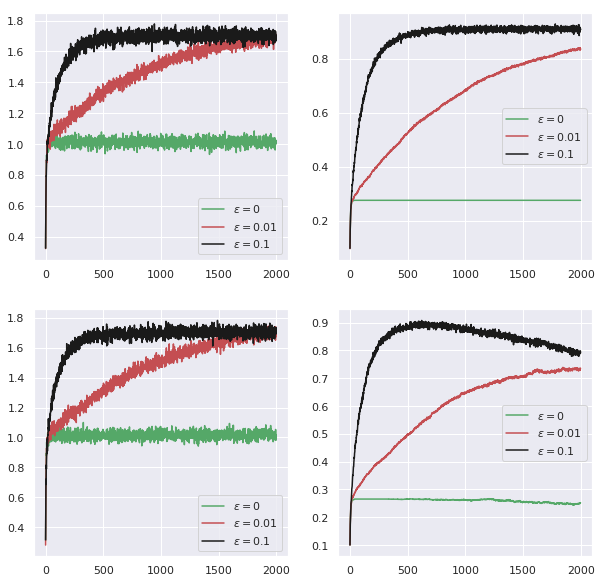

In [152]:
fig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0,0].plot(rwd_1s, 'g', label = r'$\epsilon = 0$')
ax[0,0].plot(rwd_2s, 'r', label = r'$\epsilon = 0.01$')
ax[0,0].plot(rwd_3s, 'k', label = r'$\epsilon = 0.1$')
ax[0,0].legend()

ax[0,1].plot(err_1s, 'g', label = r'$\epsilon = 0$')
ax[0,1].plot(err_2s, 'r', label = r'$\epsilon = 0.01$')
ax[0,1].plot(err_3s, 'k', label = r'$\epsilon = 0.1$')
ax[0,1].legend()

ax[1,0].plot(rwd_1ns, 'g', label = r'$\epsilon = 0$')
ax[1,0].plot(rwd_2ns, 'r', label = r'$\epsilon = 0.01$')
ax[1,0].plot(rwd_3ns, 'k', label = r'$\epsilon = 0.1$')
ax[1,0].legend()

ax[1,1].plot(err_1ns, 'g', label = r'$\epsilon = 0$')
ax[1,1].plot(err_2ns, 'r', label = r'$\epsilon = 0.01$')
ax[1,1].plot(err_3ns, 'k', label = r'$\epsilon = 0.1$')
ax[1,1].legend()

#### Epsilon greedy with $\epsilon = 0.1$ using sample average and constant ($\alpha = 0.1$) step size in stationary and nonstationary cases

In [153]:
steps = 10000
n_runs = 1000

stat = True
actions = ActionSelector(epsilon = 0.1)
update = UpdateMethod(action_selector = actions)
am = actions.epsilon_greedy
um = update.sample_avg
rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector(epsilon = 0.1)
update = UpdateMethod(action_selector = actions, alpha = 0.1)
am = actions.epsilon_greedy
um = update.constant_step

rwd_2s, err_2s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

stat = False
actions = ActionSelector(epsilon = 0.1)
update = UpdateMethod(action_selector = actions)
am = actions.epsilon_greedy
um = update.sample_avg
rwd_1ns, err_1ns = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector(epsilon = 0.1)
update = UpdateMethod(action_selector = actions, alpha = 0.1)
am = actions.epsilon_greedy
um = update.constant_step

rwd_2ns, err_2ns = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

Elapsed time: 58.79 seconds
Elapsed time: 56.20 seconds
Elapsed time: 62.36 seconds
Elapsed time: 60.45 seconds


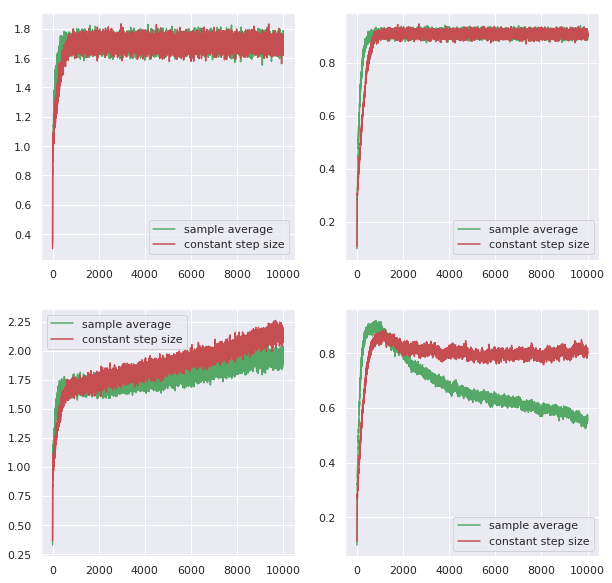

In [154]:
fig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0,0].plot(rwd_1s, 'g', label = 'sample average')
ax[0,0].plot(rwd_2s, 'r', label = 'constant step size')
ax[0,0].legend()

ax[0,1].plot(err_1s, 'g', label = 'sample average')
ax[0,1].plot(err_2s, 'r', label = 'constant step size')
ax[0,1].legend()

ax[1,0].plot(rwd_1ns, 'g', label = 'sample average')
ax[1,0].plot(rwd_2ns, 'r', label = 'constant step size')
ax[1,0].legend()

ax[1,1].plot(err_1ns, 'g', label = 'sample average')
ax[1,1].plot(err_2ns, 'r', label = 'constant step size')
ax[1,1].legend()

### Optimistic initial values

The methods mentioned (sample average and constant step) depend on $Q_1$ which means they are biased. In the sample average method the bias dissappears when each action has been taken once, since $Q_2 = Q_1+\frac{1}{1}(R_1-Q_1) = R_1$, however, in the constant step size method, the bias doesn't disappear, although it decreases exponentially as the number of times a given action is taken increases. The bias can be useful to provide prior information of the expected rewards.

Besides, initial values can be used to encourage exploration when using a greedy policy, by setting high initial values, the agent will go through each possibility before getting stuck in a greedy action. This is because in the begining the model will be dissapointed since the reward obtained is much less than the initial value, and therfore will try other options.

Optimistic initial values are not well suited for nonstationary problems because the exploration occurs only at the begining

In [155]:
steps = 1000
n_runs = 1000

stat = True
actions = ActionSelector(epsilon = 0)
update = UpdateMethod(action_selector = actions, alpha = 0.1)
am = actions.epsilon_greedy
um = update.constant_step
rwd_1, err_1 = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                     update_method = update, am = am, um = um, stationary = stat, init_values = [5]*10)

actions = ActionSelector(epsilon = 0.1)
update = UpdateMethod(action_selector = actions, alpha = 0.1)
am = actions.epsilon_greedy
um = update.constant_step
rwd_2, err_2 = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

Elapsed time: 5.92 seconds
Elapsed time: 5.87 seconds


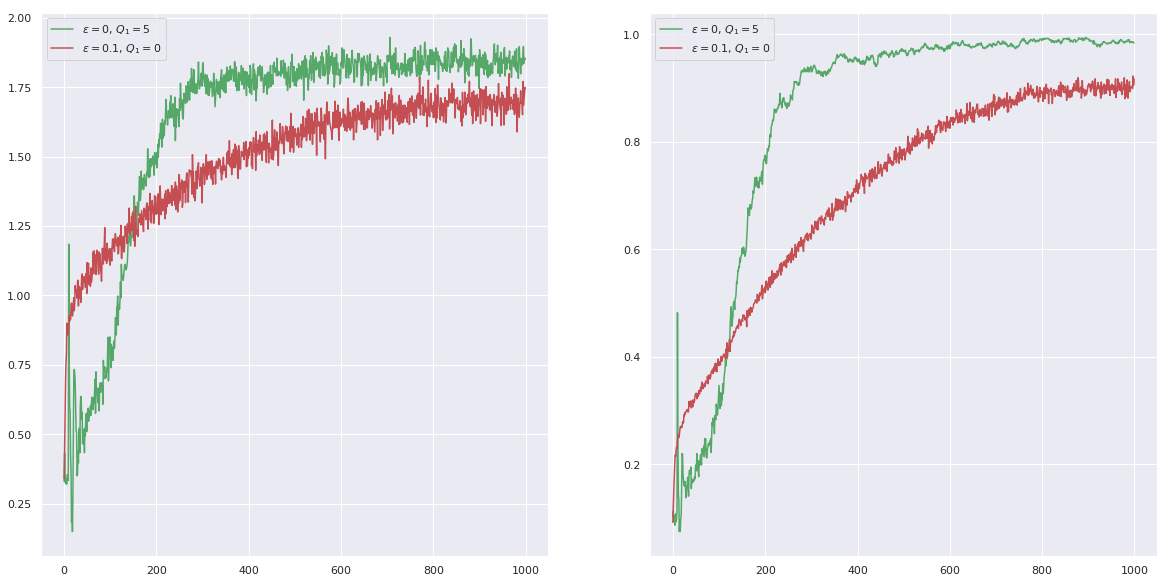

In [156]:
fig, ax = plt.subplots(1,2, figsize = (20,10))

ax[0].plot(rwd_1, 'g', label = r'$\epsilon = 0$, $Q_1 = 5$')
ax[0].plot(rwd_2, 'r', label = r'$\epsilon = 0.1$, $Q_1 = 0$')
ax[0].legend()

ax[1].plot(err_1, 'g', label = r'$\epsilon = 0$, $Q_1 = 5$')
ax[1].plot(err_2, 'r', label = r'$\epsilon = 0.1$, $Q_1 = 0$')
ax[1].legend()

#### Exercise 2.6

In the begining the model will explore every action, since every time it will be dissapointed and will end up choosing an action which still is in an optimistic value. When all actions are explored, it's more likely that the best option has the higher $Q$ value, resulting in the model choosing that action most of the time, which is shown in the graph as a spike around step 10 (the number of possible actions).

### Upper-Confidence-Bound action selection

Although the $\epsilon$-greedy method allows exploration, it doesn't measure the potential of each action to actually be optimal, there is no preference. It would be better if we could select explore but having information about the potential reward of each action, this is, taking into account how close are the estimates to being maximal and the uncertainty in those estimates. A policy that allows this is:

$A_t = argmax_a\left[Q_t(a)+c\sqrt{\frac{\ln{t}}{N_t(a)}}\right]$

$N_t(a)$ is the number of times action $a$ has been taken prior to step $t$, $c>0$ controls the degree of exploration. $N_t(a) = 0$ means $a$ is a maximizing action.

The square-root term acts as a measure of uncertainty of the estimate $Q_t(a)$. Therefoe, the quantity to maximize is an upper bound on the true reward for taking $a$. Notice that each selection of $a$ reduces the uncertainty, since $N_t(a)$ increases, besides, when an action other than $a$ is taken $t$ increases while $N$ remains the same, thus increasing the uncertainty.

Although UCB is better than $\epsilon$-greedy in the 10-armed testbed, it is not easily applicable to more complex problems of reinforcement learning, in particular nonstationary problems and large state-spaces

In [157]:
steps = 1000
n_runs = 1000

stat = True
actions = ActionSelector(epsilon = 0.1)
update = UpdateMethod(action_selector = actions)
am = actions.epsilon_greedy
um = update.sample_avg
rwd_1, err_1 = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector(c = 2)
update = UpdateMethod(action_selector = actions)
am = actions.upper_confidence_bound
um = update.sample_avg
rwd_2, err_2 = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

Elapsed time: 5.98 seconds
Elapsed time: 32.14 seconds


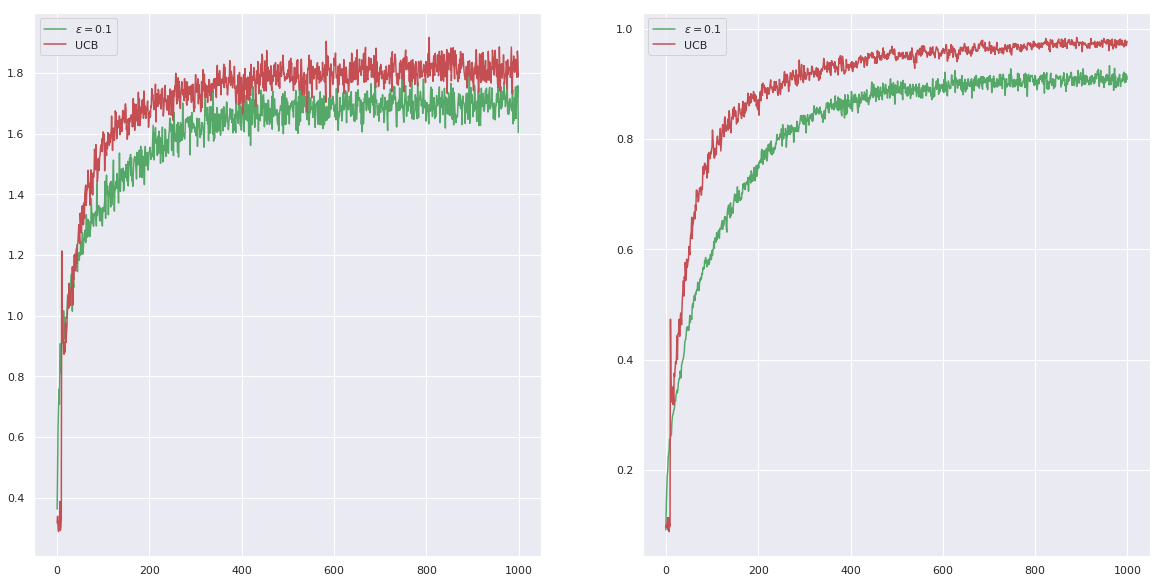

In [158]:
fig, ax = plt.subplots(1,2, figsize = (20,10))

ax[0].plot(rwd_1, 'g', label = r'$\epsilon = 0.1$')
ax[0].plot(rwd_2, 'r', label = 'UCB')
ax[0].legend()

ax[1].plot(err_1, 'g', label = r'$\epsilon = 0.1$')
ax[1].plot(err_2, 'r', label = 'UCB')
ax[1].legend()

### Gradient bandit algorithms

Instead of selecting actions based on action value estimates we can define a preference for each action $H_t(a)$ and select based on those preferences. Notice that the preferences are relative and are not rewards, that is a highr value only tells which action to take, not the actual rewards the model will receive. These preferences can be defined with a softmax distribution as follows.

$Pr\{A_t=a\} = \frac{e^{H_t(a)}}{\sum_{b=1}^ke^{H_t(a)}} = \pi_t(a)$

$\pi_t(a)$ is the probability of choosing action $a$ at time $t$. Initially, all probabilities are the same (e.g. $H_1(a) = 0$). The learning algorithm is called stochastic gradient ascent,and is given by:

$H_{t+1}=H_t(A_t)+\alpha(R_t-\bar{R_t})(1-\pi_t(A_t)),\quad for \quad a = A_t$

$H_{t+1}(a) = H_t(a) -\alpha(R_t-\bar{R_t})\pi_t(a),\quad for \quad a\neq A_t$

#### Exercise 2.7

When there are only 2 actions:

$\pi_t(a_1) = \frac{e^{H_t(a_1)}}{e^{H_t(a_1)}+e^{H_t(a_2)}} = \frac{e^{H_t(a_1)}}{e^{H_t(a_2)}\left(e^{H_t(a_1)-H_t(a_2)}+1\right)} = \frac{e^{H_t(a_1)-H_t(a_2)}}{\left(e^{H_t(a_1)-H_t(a_2)}+1\right)}$

$\pi_t(a_2) = \frac{e^{H_t(a_2)}}{e^{H_t(a_1)}+e^{H_t(a_2)}} = \frac{e^{H_t(a_2)}}{e^{H_t(a_2)}\left(e^{H_t(a_1)-H_t(a_2)}+1\right)} = \frac{1}{\left(e^{H_t(a_1)-H_t(a_2)}+1\right)}$

Defining $H_t(a-1)-H_t(a_2) = p$:

$\pi_t(a_1) = \frac{e^p}{e^p+1}$

$\pi_t(a_2) = \frac{1}{e^p+1}$

Which is the definition of the sigmoid - logistic function. We can also see that the two expressions sum 1.

In [159]:
steps = 1000
n_runs = 1000

test = ArmedTestbed(mean = 4)
stat = True

actions = ActionSelector()
update = UpdateMethod(action_selector = actions, alpha = 0.1, baseline = True)
am = actions.gradient_bandit_action
um = update.gradient_bandit_update
rwd_1, err_1 = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector()
update = UpdateMethod(action_selector = actions, alpha = 0.4, baseline = True)
am = actions.gradient_bandit_action
um = update.gradient_bandit_update
rwd_2, err_2 = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector()
update = UpdateMethod(action_selector = actions, alpha = 0.1, baseline = False)
am = actions.gradient_bandit_action
um = update.gradient_bandit_update
rwd_3, err_3 = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

actions = ActionSelector()
update = UpdateMethod(action_selector = actions, alpha = 0.4, baseline = False)
am = actions.gradient_bandit_action
um = update.gradient_bandit_update
rwd_4, err_4 = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                       update_method = update, am = am, um = um, stationary = stat)

Elapsed time: 49.60 seconds
Elapsed time: 49.60 seconds
Elapsed time: 48.76 seconds
Elapsed time: 48.91 seconds


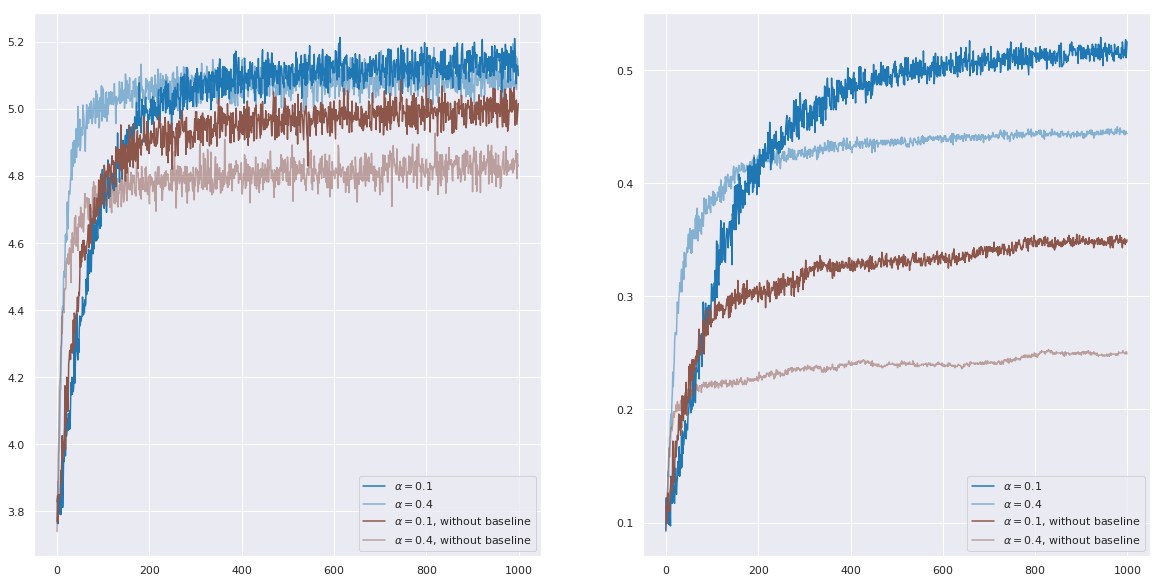

In [160]:
fig, ax = plt.subplots(1,2, figsize = (20,10))

ax[0].plot(rwd_1, 'tab:blue', label = r'$\alpha = 0.1$')
ax[0].plot(rwd_2, 'tab:blue', alpha = .5, label = r'$\alpha = 0.4$')
ax[0].plot(rwd_3, 'tab:brown', label = r'$\alpha = 0.1$, without baseline')
ax[0].plot(rwd_4, 'tab:brown', alpha = .5, label = r'$\alpha = 0.4$, without baseline')
ax[0].legend() 

ax[1].plot(err_1, 'tab:blue', label = r'$\alpha = 0.1$')
ax[1].plot(err_2, 'tab:blue', alpha = .5, label = r'$\alpha = 0.4$')
ax[1].plot(err_3, 'tab:brown', label = r'$\alpha = 0.1$, without baseline')
ax[1].plot(err_4, 'tab:brown', alpha = .5, label = r'$\alpha = 0.4$, without baseline')
ax[1].legend()

### Parameter study

In [70]:
test = ArmedTestbed()
steps = 1000
n_runs = 1000
stat = True

epsilon = [2**i for i in range(-7, -1)]
reward_epsilon = []
for e in epsilon:
    actions = ActionSelector(epsilon = e)
    update = UpdateMethod(action_selector = actions)
    am = actions.epsilon_greedy
    um = update.sample_avg
    rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                          update_method = update, am = am, um = um, stationary = stat)
    reward_epsilon.append(np.mean(rwd_1s))

init_values = [2**i for i in range(-2, 3)]
reward_optimistic = []
for q in init_values:
    actions = ActionSelector(epsilon = 0)
    update = UpdateMethod(action_selector = actions, alpha = 0.1)
    am = actions.epsilon_greedy
    um = update.constant_step
    rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                          update_method = update, am = am, um = um, stationary = stat, init_values = [q]*10)
    reward_optimistic.append(np.mean(rwd_1s))
    
c = [2**i for i in range(-4, 3)]
reward_ucb = []
for i in c:
    actions = ActionSelector(c = i)
    update = UpdateMethod(action_selector = actions)
    am = actions.upper_confidence_bound
    um = update.sample_avg
    rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                          update_method = update, am = am, um = um, stationary = stat)
    reward_ucb.append(np.mean(rwd_1s))
    
alpha = [2**i for i in range(-5, 3)]
reward_gb = []
for a in alpha:
    actions = ActionSelector()
    update = UpdateMethod(action_selector = actions, alpha = a)
    am = actions.gradient_bandit_action
    um = update.gradient_bandit_update
    rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                          update_method = update, am = am, um = um, stationary = stat)
    reward_gb.append(np.mean(rwd_1s))

Elapsed time: 6.90 seconds
Elapsed time: 7.01 seconds
Elapsed time: 7.04 seconds
Elapsed time: 6.73 seconds
Elapsed time: 6.31 seconds
Elapsed time: 6.09 seconds
Elapsed time: 6.41 seconds
Elapsed time: 6.22 seconds
Elapsed time: 6.20 seconds
Elapsed time: 6.13 seconds
Elapsed time: 6.35 seconds
Elapsed time: 31.11 seconds
Elapsed time: 31.08 seconds
Elapsed time: 31.64 seconds
Elapsed time: 31.54 seconds
Elapsed time: 31.72 seconds
Elapsed time: 31.87 seconds
Elapsed time: 32.08 seconds
Elapsed time: 50.21 seconds
Elapsed time: 49.86 seconds
Elapsed time: 50.31 seconds
Elapsed time: 49.52 seconds
Elapsed time: 49.61 seconds
Elapsed time: 50.09 seconds
Elapsed time: 49.77 seconds
Elapsed time: 49.45 seconds


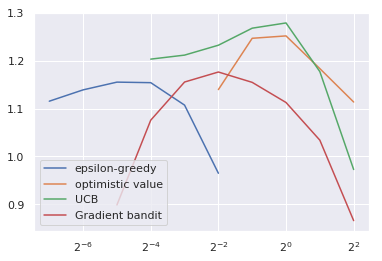

In [71]:
fix, ax = plt.subplots()
ax.plot(epsilon, reward_epsilon, label = 'epsilon-greedy')
ax.plot(init_values, reward_optimistic, label = 'optimistic value')
ax.plot(c, reward_ucb, label = 'UCB')
ax.plot(alpha, reward_gb, label = 'Gradient bandit')
ax.set_xscale('log', basex=2)
plt.legend()

In [161]:
steps = 200000
n_runs = 1000
stat = False

epsilon = [2**i for i in range(-7, -1)]
reward_epsilon = []
for e in epsilon:
    actions = ActionSelector(epsilon = e)
    update = UpdateMethod(action_selector = actions)
    am = actions.epsilon_greedy
    um = update.sample_avg
    rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                          update_method = update, am = am, um = um, stationary = stat)
    reward_epsilon.append(np.mean(rwd_1s[100000:]))

alpha_1 = [2**i for i in range(-5, 2)]
reward_constant = []
for a in alpha_1:
    actions = ActionSelector(epsilon = 0.1)
    update = UpdateMethod(action_selector = actions, alpha = a)
    am = actions.epsilon_greedy
    um = update.constant_step
    rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                          update_method = update, am = am, um = um, stationary = stat)
    reward_constant.append(np.mean(rwd_1s[100000:]))
    
init_values = [2**i for i in range(-2, 3)]
reward_optimistic = []
for q in init_values:
    actions = ActionSelector(epsilon = 0)
    update = UpdateMethod(action_selector = actions, alpha = 0.1)
    am = actions.epsilon_greedy
    um = update.constant_step
    rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                          update_method = update, am = am, um = um, stationary = stat, init_values = [q]*10)
    reward_optimistic.append(np.mean(rwd_1s[100000:]))
    
c = [2**i for i in range(-4, 3)]
reward_ucb = []
for i in c:
    actions = ActionSelector(c = i)
    update = UpdateMethod(action_selector = actions)
    am = actions.upper_confidence_bound
    um = update.sample_avg
    rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                          update_method = update, am = am, um = um, stationary = stat)
    reward_ucb.append(np.mean(rwd_1s[100000:]))
    
alpha_2 = [2**i for i in range(-5, 3)]
reward_gb = []
for a in alpha_2:
    actions = ActionSelector()
    update = UpdateMethod(action_selector = actions, alpha = a)
    am = actions.gradient_bandit_action
    um = update.gradient_bandit_update
    rwd_1s, err_1s = train(test, steps = steps, n_runs = n_runs, action_selector = actions, 
                          update_method = update, am = am, um = um, stationary = stat)
    reward_gb.append(np.mean(rwd_1s[100000:]))

Elapsed time: 1299.27 seconds
Elapsed time: 1293.25 seconds
Elapsed time: 1288.82 seconds
Elapsed time: 1283.96 seconds
Elapsed time: 1252.94 seconds
Elapsed time: 1225.61 seconds
Elapsed time: 1218.07 seconds
Elapsed time: 1226.24 seconds
Elapsed time: 1224.05 seconds
Elapsed time: 1213.54 seconds
Elapsed time: 1207.73 seconds
Elapsed time: 1236.64 seconds
Elapsed time: 1225.84 seconds
Elapsed time: 1253.53 seconds
Elapsed time: 1257.27 seconds
Elapsed time: 1416.07 seconds
Elapsed time: 1417.07 seconds
Elapsed time: 1321.16 seconds
Elapsed time: 6271.53 seconds
Elapsed time: 6315.33 seconds
Elapsed time: 6283.55 seconds
Elapsed time: 6320.22 seconds
Elapsed time: 6366.58 seconds
Elapsed time: 6390.61 seconds
Elapsed time: 6420.85 seconds
Elapsed time: 10045.18 seconds
Elapsed time: 10009.61 seconds
Elapsed time: 10053.64 seconds
Elapsed time: 9997.76 seconds
Elapsed time: 10105.34 seconds
Elapsed time: 10133.90 seconds
Elapsed time: 10003.50 seconds
Elapsed time: 9754.15 seconds


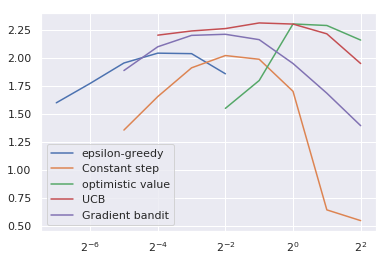

In [144]:
fix, ax = plt.subplots()
ax.plot(epsilon, reward_epsilon, label = 'epsilon-greedy')
ax.plot(alpha_1, reward_constant, label = 'Constant step')
ax.plot(init_values, reward_optimistic, label = 'optimistic value')
ax.plot(c, reward_ucb, label = 'UCB')
ax.plot(alpha_2,reward_gb, label = 'Gradient bandit')
ax.set_xscale('log', basex=2)
plt.legend()